# Подготовка к работе
Создадим структуру проекта и загрузим данные в `/data` директорию. Нет необходимости использовать git lfs из-за небольшого размера файлов.

Проведем подготовительные работы с настройкой виртуального окружения. 
```bash
pip install -r requirements.txt
```

# Анализ данных
Загрузим данные для дальнейшей работы с ними.

In [1]:
import sys
from loguru import logger

from research.data_tools.data_manager import DataManager

logger.remove()
log_level = 'INFO'
logger.add(sys.stderr, level=log_level)
print(f'Set logger log_level {log_level}')

Set logger log_level INFO


In [8]:
customers_data_file = r'data/customers.tsv'
sales_data_file = r'data/sales.tsv'

data_manager = DataManager(customers_data_file, sales_data_file, process_data=False)

Выведем первые 5 строк каждого датафрейма для знакомства со структурой.

In [9]:
rows_num = 5
print(f'Customers dataframe the first {rows_num} rows\n: {data_manager.customers_df.head(rows_num)}\n')
print(f'Sales dataframe the first {rows_num} rows\n: {data_manager.sales_df.head(rows_num)}')

Customers dataframe the first 5 rows
:   year_month ira customers_type  amount_of_customers  date_idx
0 2017-01-01  AC         Archer                679.0         1
1 2017-01-01  AC           Monk               1070.0         1
2 2017-01-01  AC          Dwarf                610.0         1
3 2017-01-01  AC        Centaur               1315.0         1
4 2017-01-01  AC        Gremlin               1554.0         1

Sales dataframe the first 5 rows
:   year_month    location ira product_category           brand   sku_id  \
0 2017-01-01  Alpha City  AC       Chocolates         Cadbury  sku #79   
1 2017-01-01  Alpha City  AC       Chocolates  Ferrero Rocher  sku #15   
2 2017-01-01  Alpha City  AC       Chocolates  Ferrero Rocher  sku #16   
3 2017-01-01  Alpha City  AC       Chocolates  Ferrero Rocher  sku #22   
4 2017-01-01  Alpha City  AC       Chocolates  Ferrero Rocher  sku #28   

   item_per_bundle     shape with_alcohol  filling   volume     price  \
0                1  Standart 

Выведем различные статистики для проверки валидности данных. Здесь возникли вопросы к данным в столбце "volume", потому что ожидалось, что они будут типа int (вместо float). Также было отмечено, что для некоторых сэмплов не указана цена товара.
Некоторые допущения: под "штукой" будем подразумевать упаковку, а именно n единиц некоторого товара, в связи с тем, что для уникального SKU число единиц товара в упаковке одно и то же.

In [10]:
data_manager.get_df_main_info(data_manager.customers_df, 'customer_df')
data_manager.get_df_main_info(data_manager.sales_df, 'sales_df')

customer_df dataframe analysis

customer_df dataframe shape: (1980, 5)

Dataframe cols types:
year_month             datetime64[ns]
ira                            object
customers_type                 object
amount_of_customers           float64
date_idx                        int64
dtype: object

Empty entities number for each column:
year_month             0
ira                    0
customers_type         0
amount_of_customers    0
date_idx               0
dtype: int64

Null entities number for each column:
year_month             0
ira                    0
customers_type         0
amount_of_customers    0
date_idx               0
dtype: int64

Statistics for each number type column:
       amount_of_customers    date_idx
count          1980.000000  1980.00000
mean           2435.587879    17.00000
std            5167.467171     9.52431
min               2.000000     1.00000
25%             321.750000     9.00000
50%             819.000000    17.00000
75%            1779.250000    25.

Визуализируем график объема продаж для различных sku_id и соответствующих локаций для каждого sku_id.Также рассмотрим боксплоты для распределения цены для разных sku_id и распределение цены для каждой sku_id - location комбинации. Здесь можно добавить еще большое количество пунктов, которые хочется проанализировать, но на которые на текущий момент не хватило времени. 

Основной вывод в результате анализа текущих графиков заключался в обнаружении некоторых локаций для некоторых sku_id, в которых нет обнаружено актуальной информации для последнего месяца. Было принято решение исключить такие данные из рассмотрения из-за неактуальности. 

Было принято решение заменить отсутствующие значения цены на значение средней цены в текущей локации для текущего sku_id.

Также было обнаружено, что число покупателей существует не для всех допустимых локаций, в связи с чем такие данные тоже были удалены из рассмотрения.

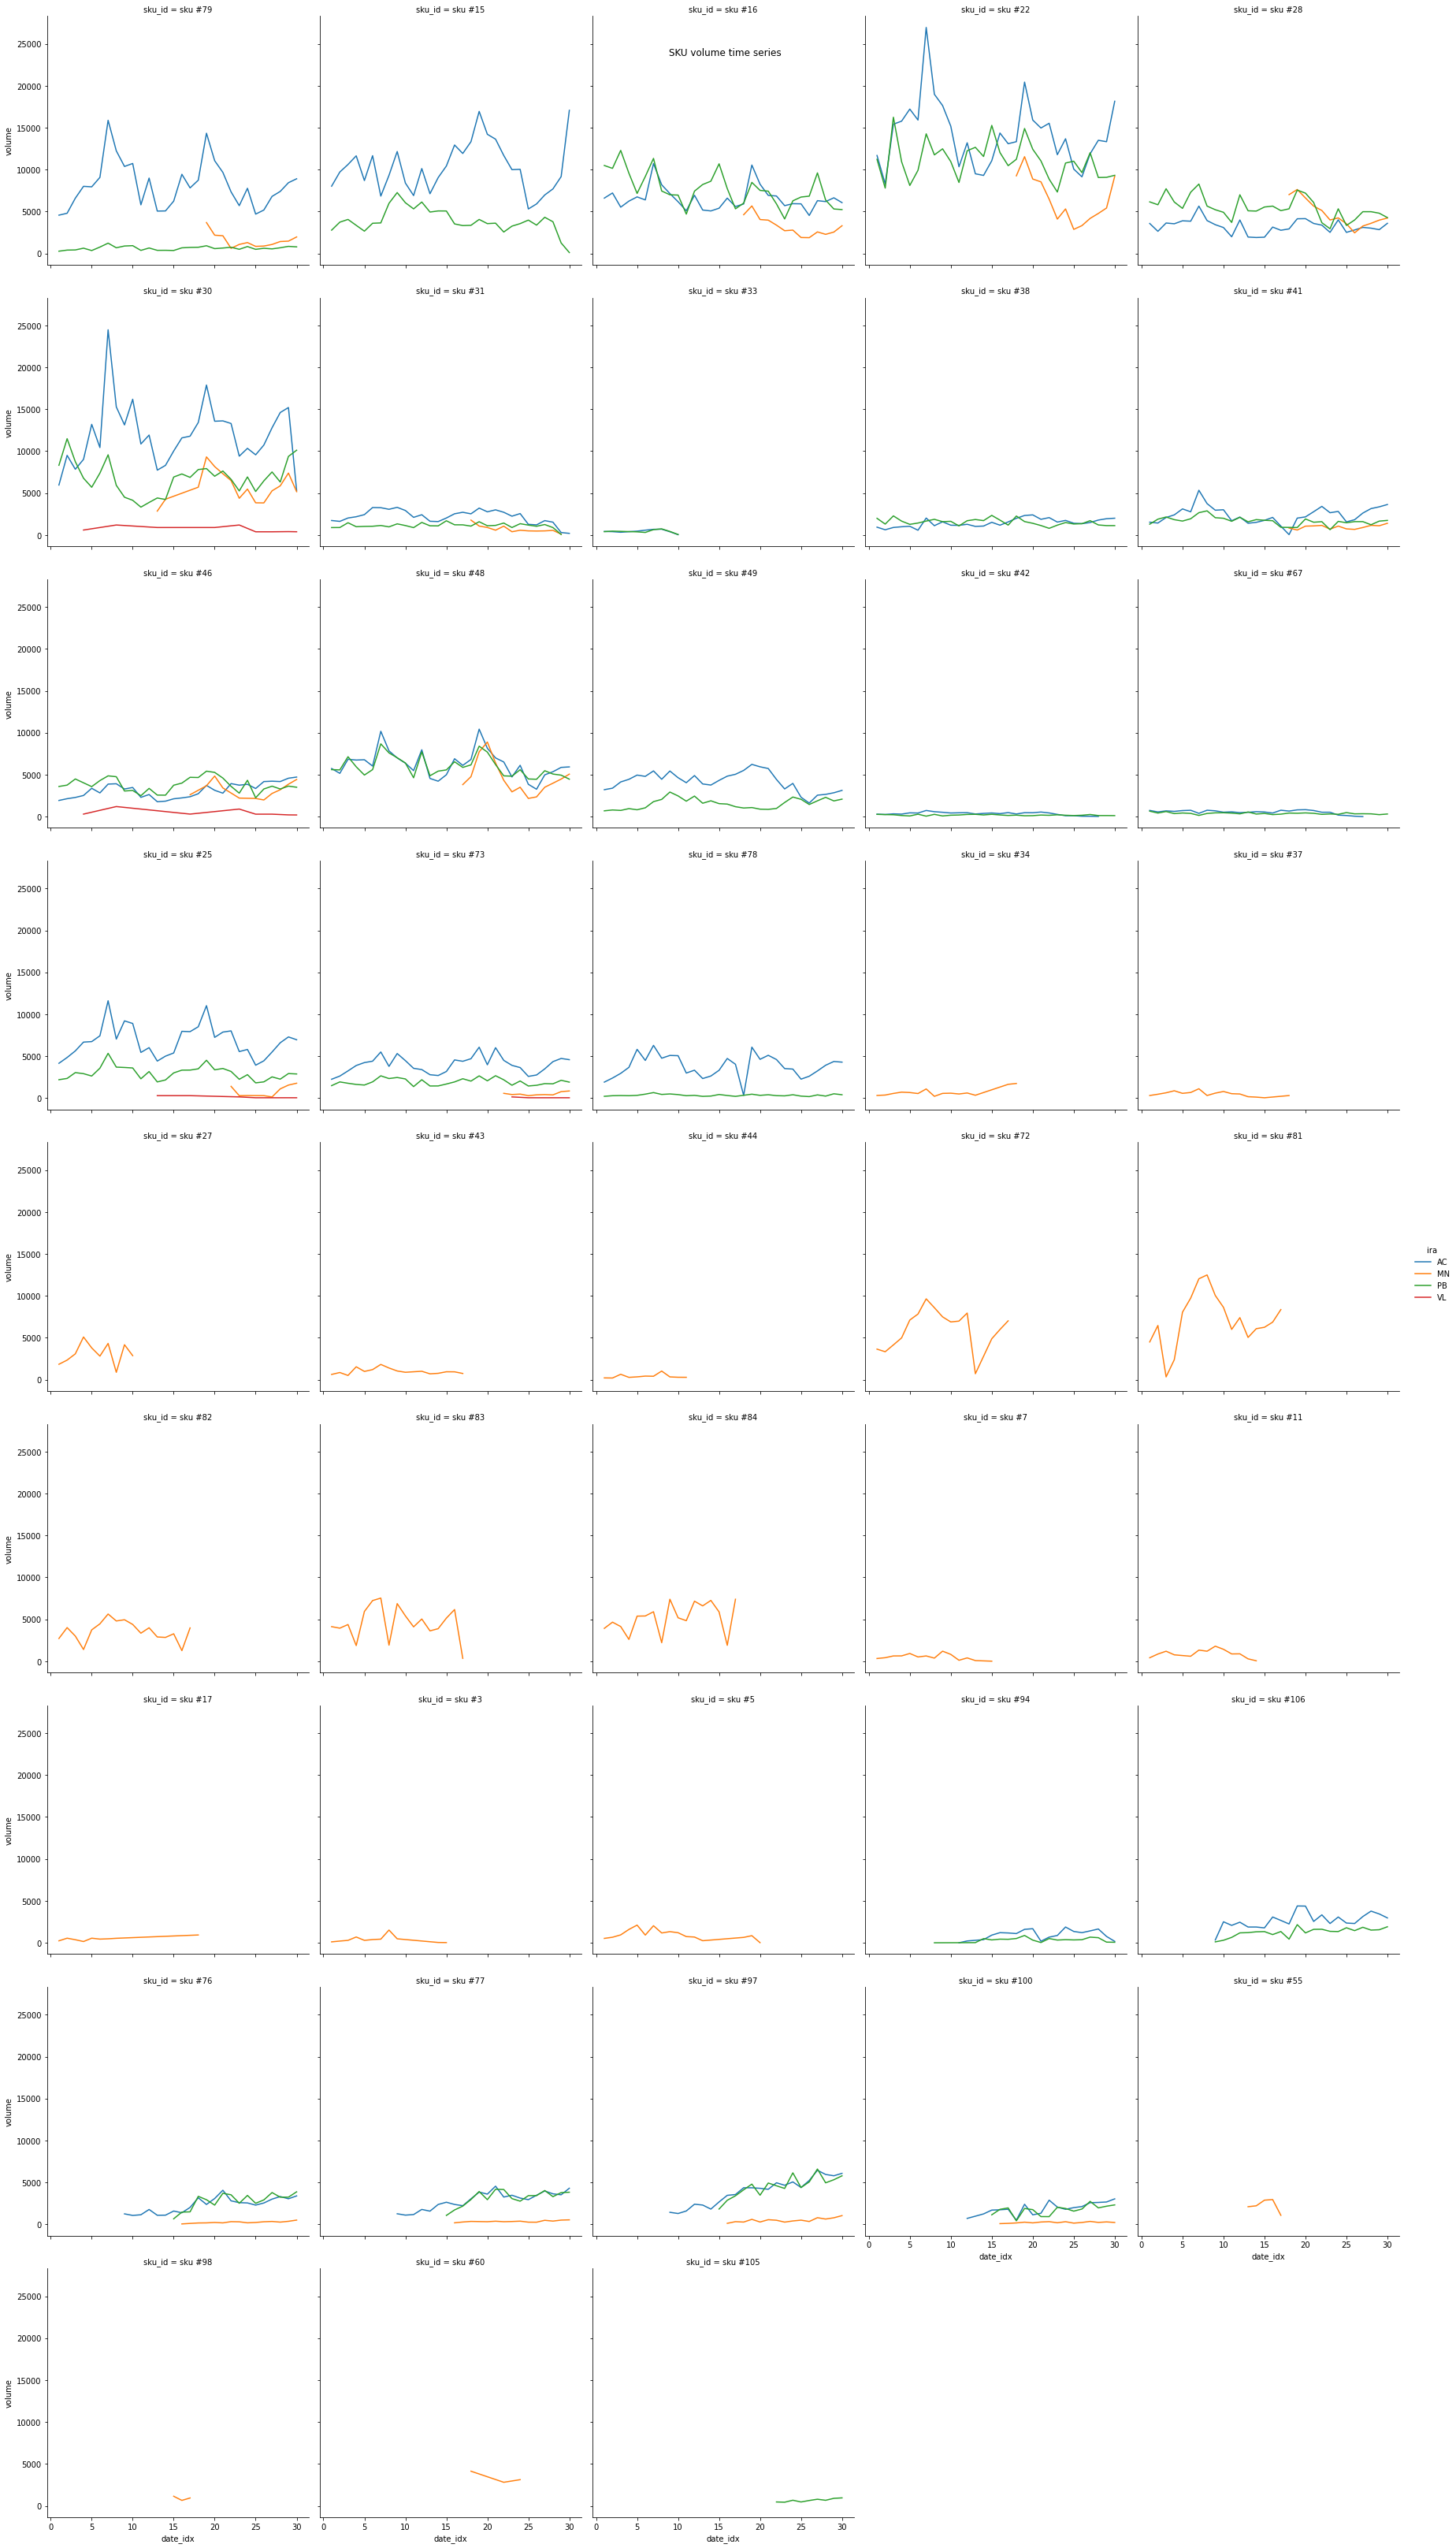

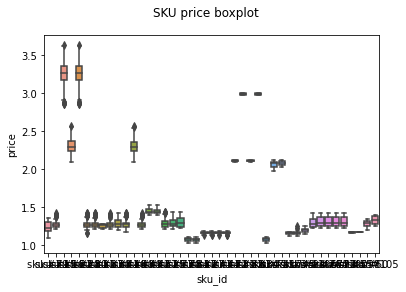

<Figure size 432x288 with 0 Axes>

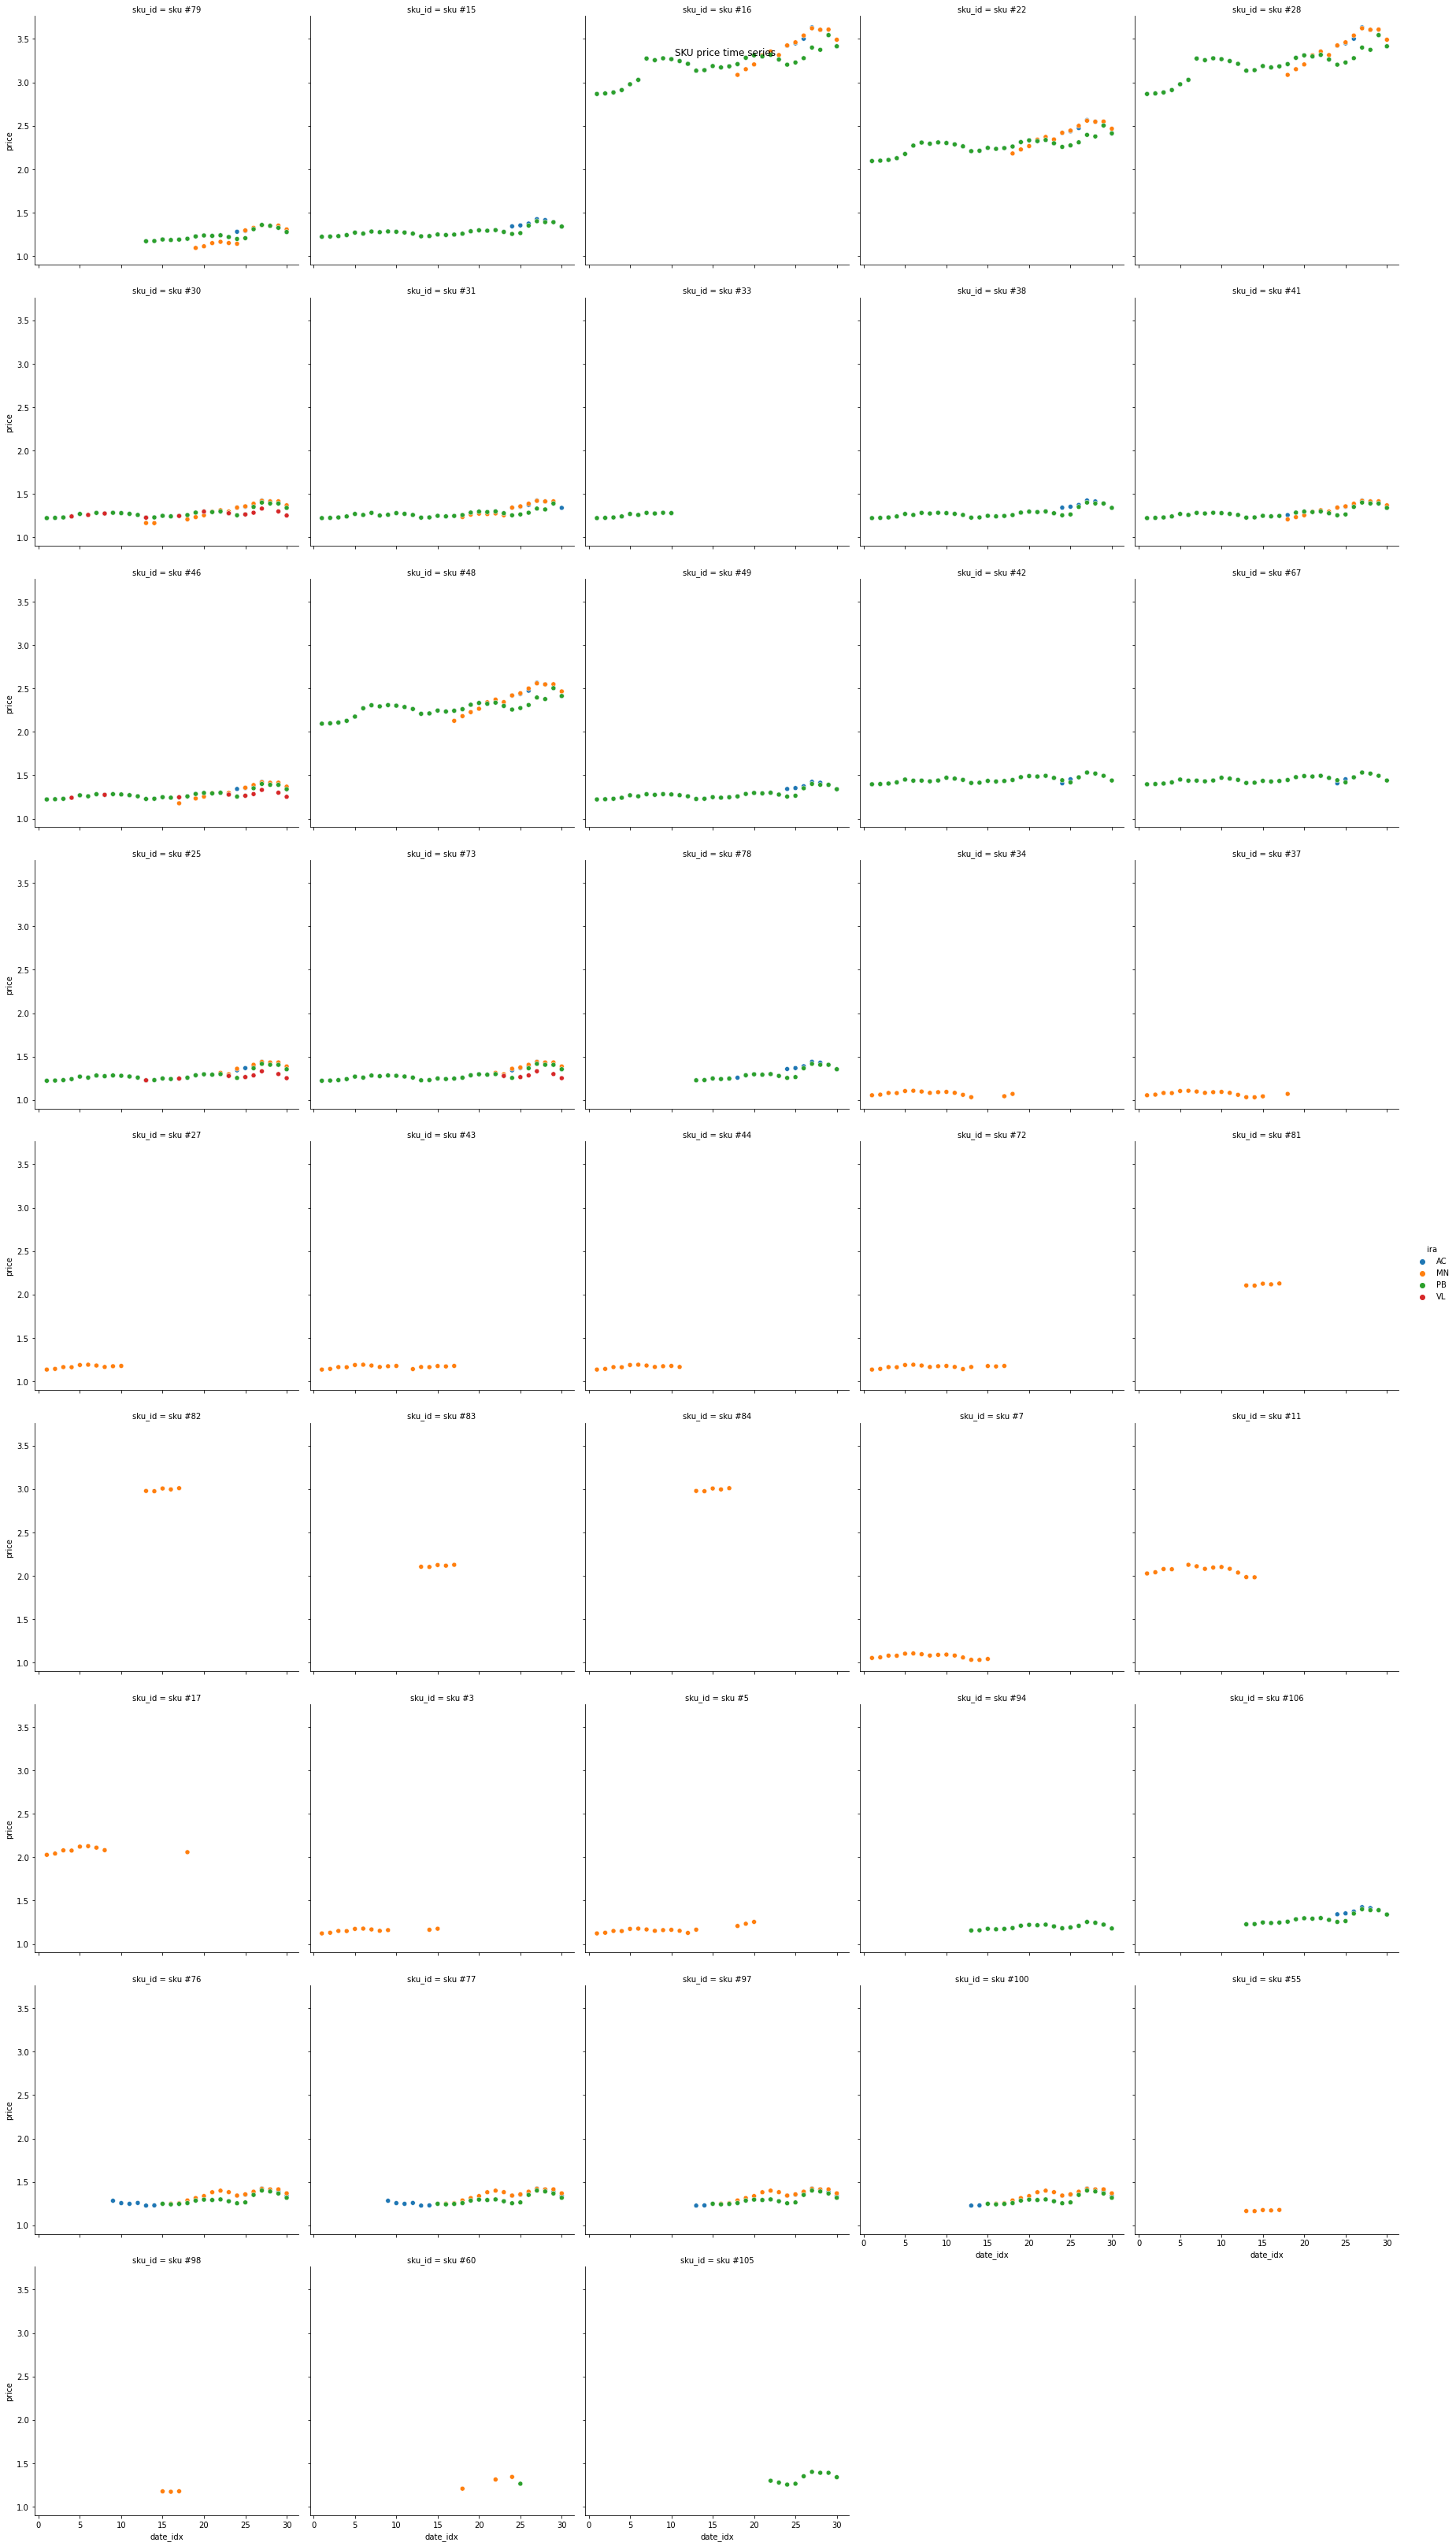

In [11]:
data_manager.vis_sales()

Пересоздадим менеджер данных с флагом для препроцессинга и выведем новые графики. Увидим, что мы исключили из рассмотрения некоторые sku_id - ira комбинации. Также можно было бы подумать над исключением из рассмотрения данных, для которых недостаточно наблюдений.

2022-02-21 18:27:47.477 | WARNING  | research.data_tools.data_manager:add_customers_count:105 - NaN customers in some region.


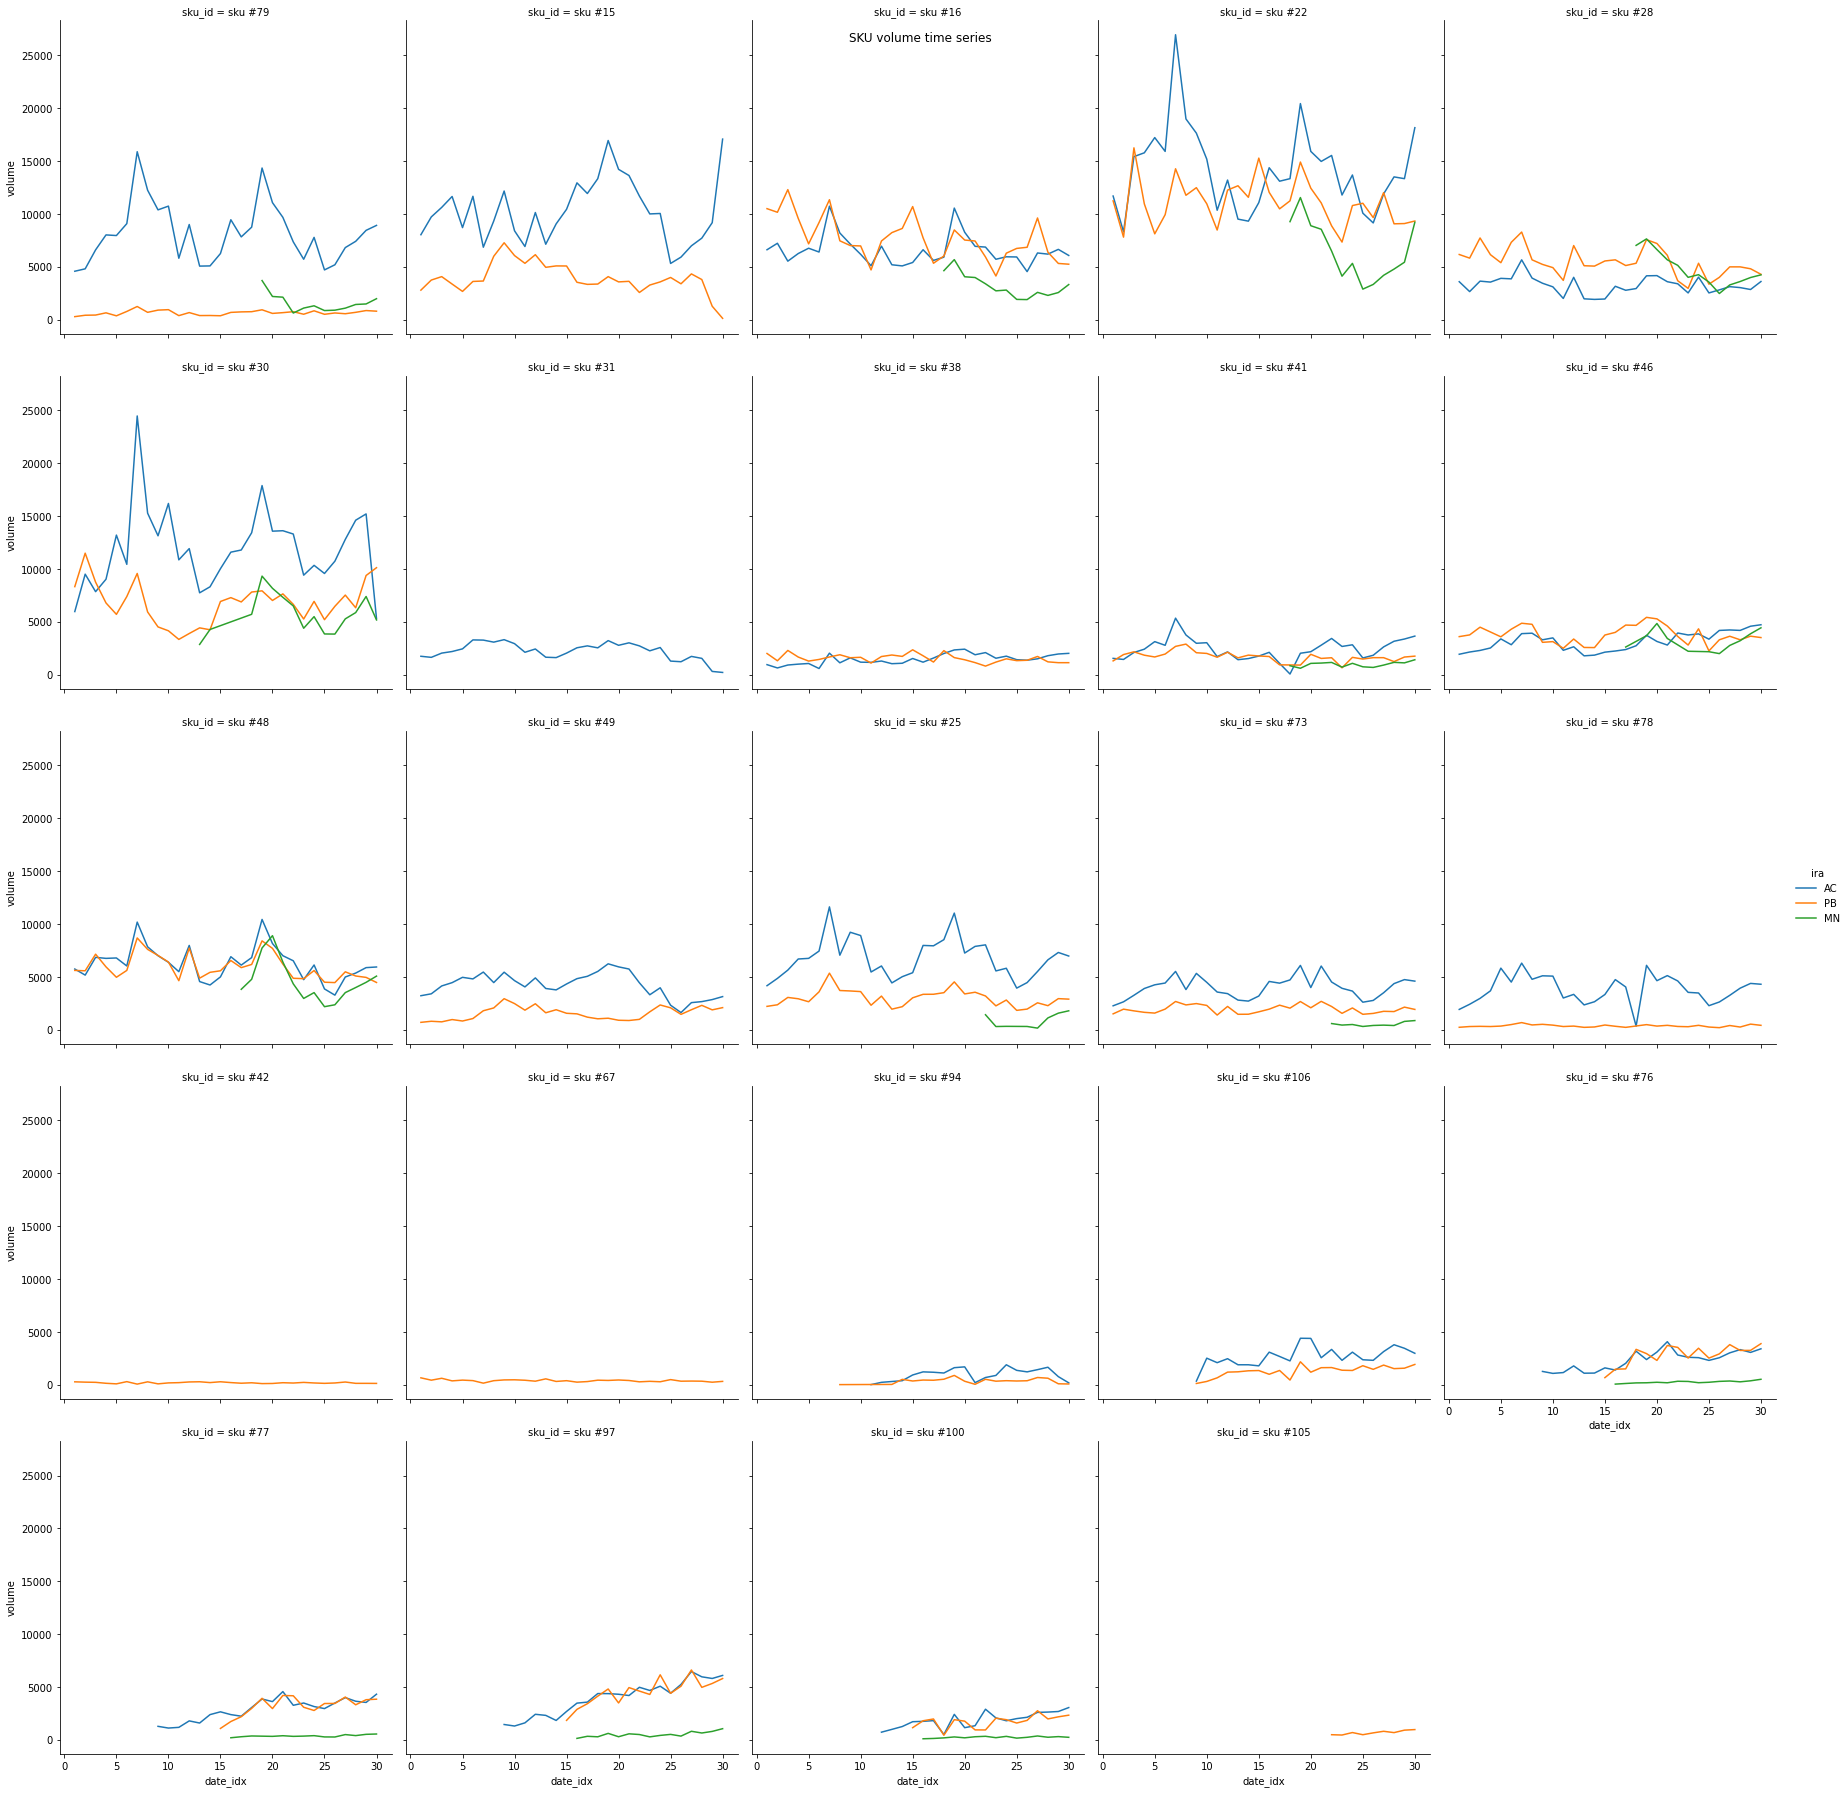

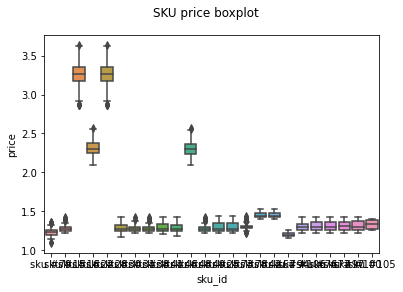

<Figure size 432x288 with 0 Axes>

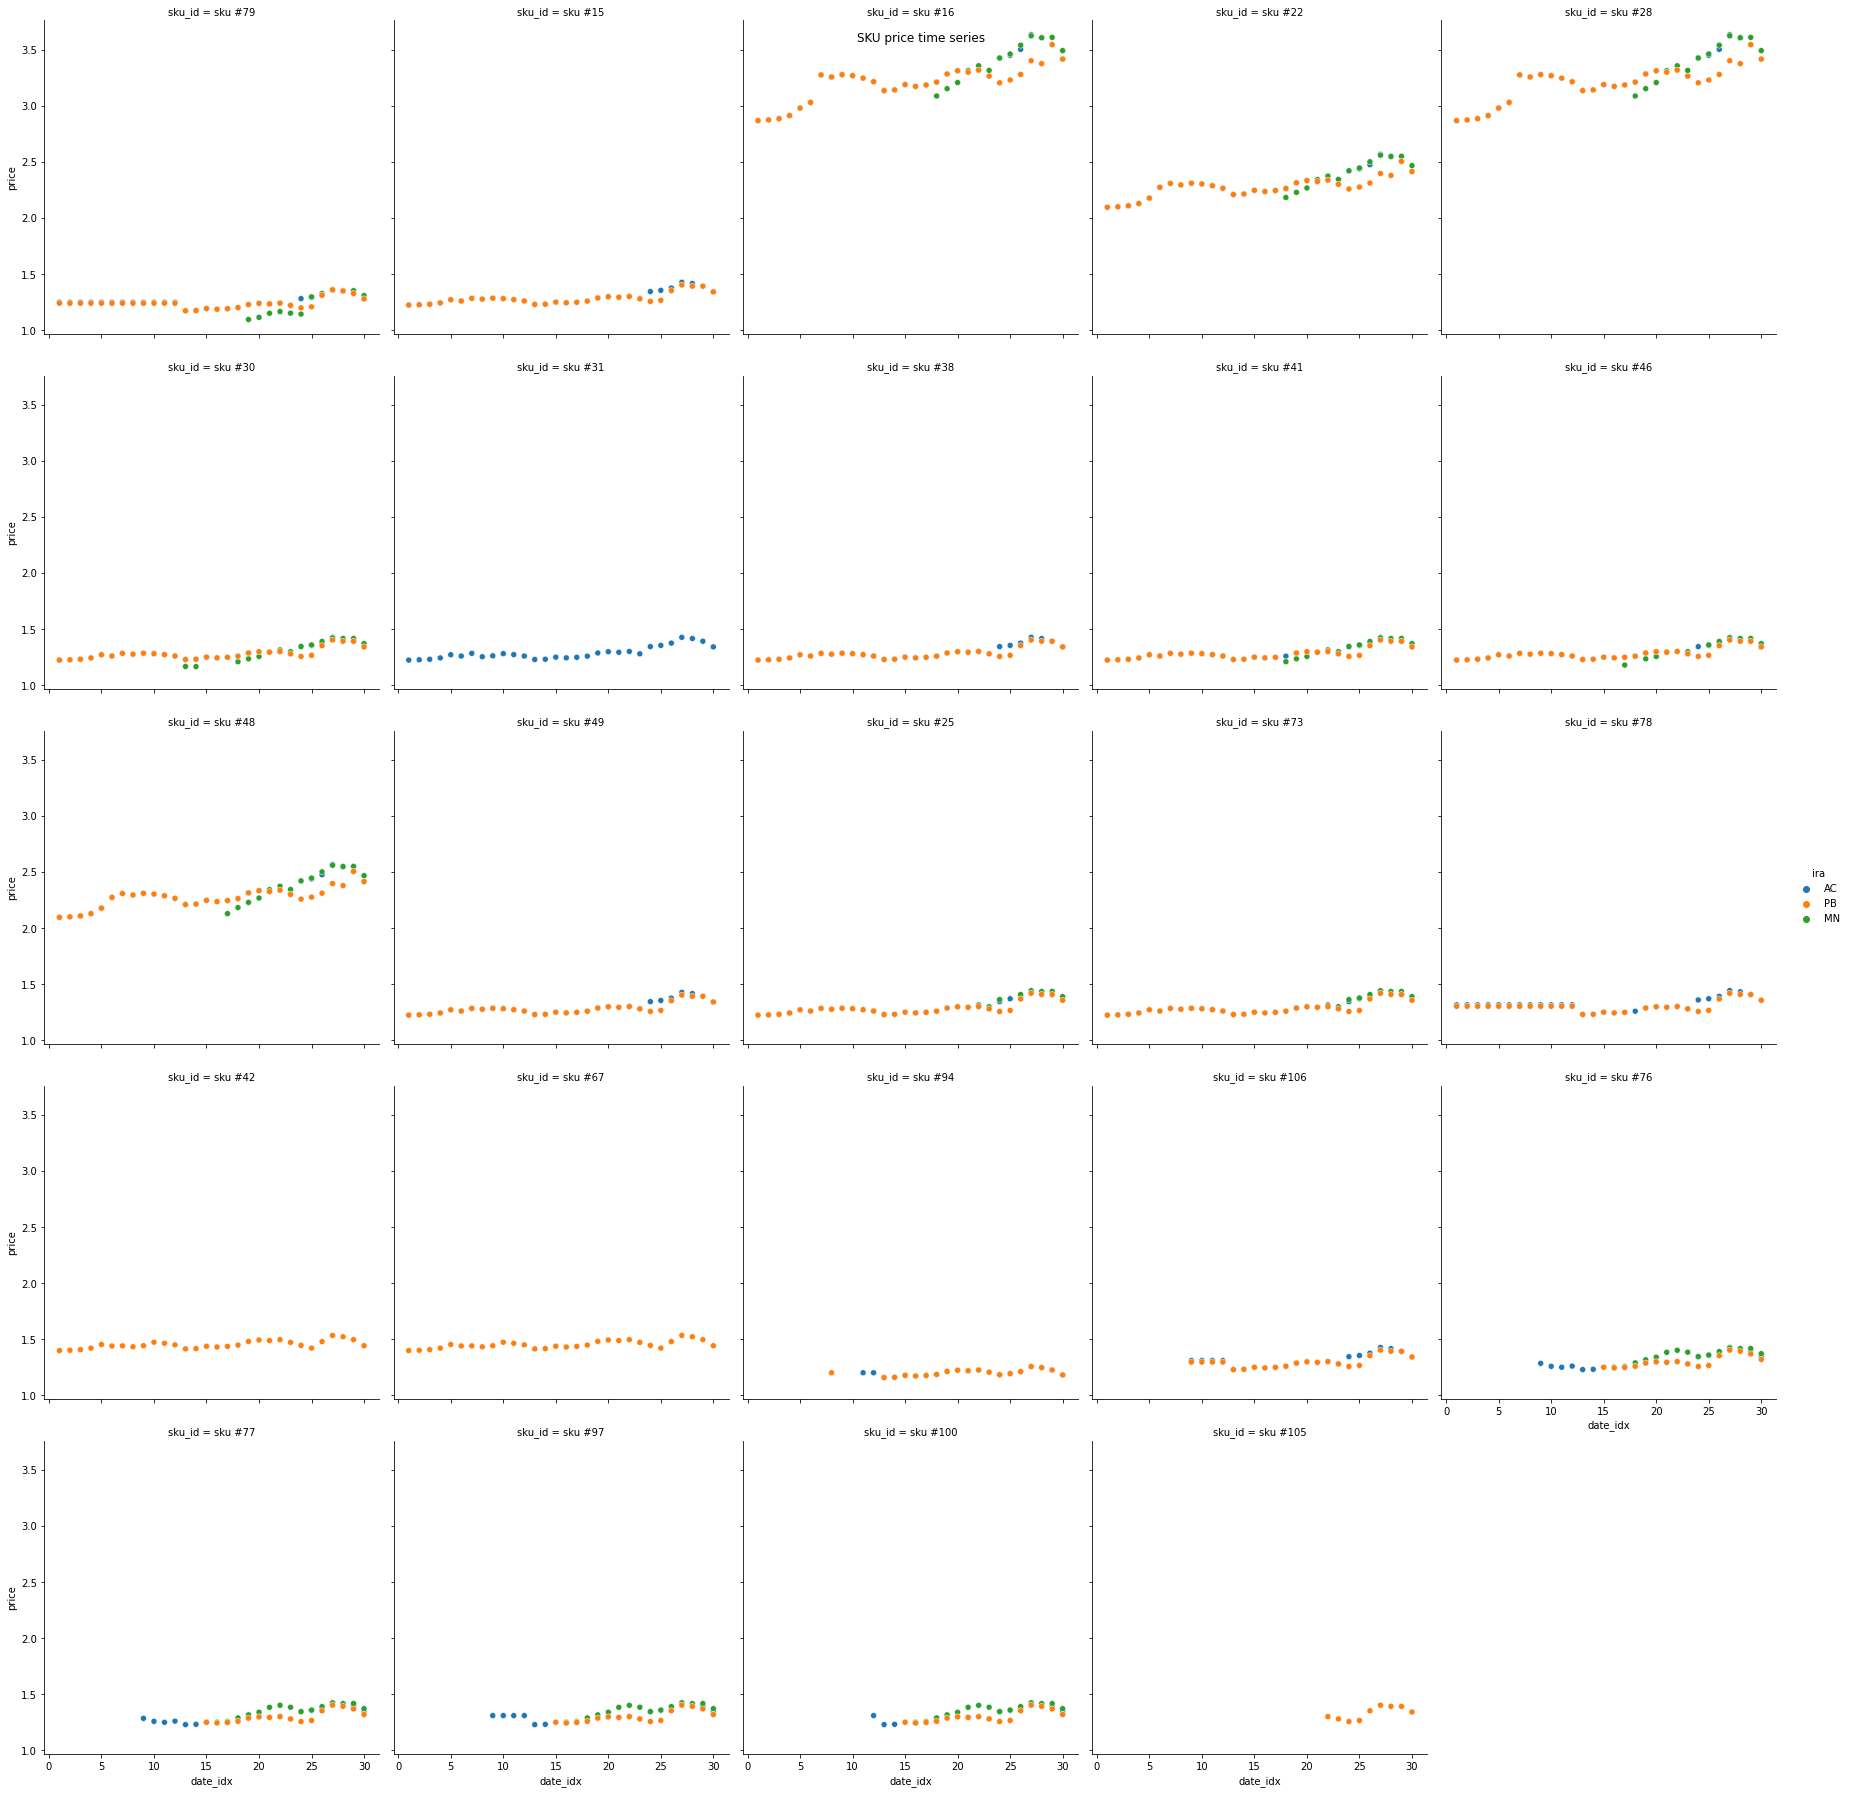

In [12]:
data_manager = DataManager(customers_data_file, sales_data_file, process_data=True)
data_manager.vis_sales()

Посмотрим список sku_id - ira комбинаций, которые мы исключили из анализа.

In [16]:
print(f'Problem sku - ira: {data_manager.problem_cases}')
print(f'Problem date_idx - ira: {data_manager.problem_date_ira}')

Problem sku - ira: [['sku #33', 'AC'], ['sku #42', 'AC'], ['sku #67', 'AC'], ['sku #34', 'MN'], ['sku #37', 'MN'], ['sku #27', 'MN'], ['sku #43', 'MN'], ['sku #44', 'MN'], ['sku #72', 'MN'], ['sku #81', 'MN'], ['sku #82', 'MN'], ['sku #83', 'MN'], ['sku #84', 'MN'], ['sku #7', 'MN'], ['sku #11', 'MN'], ['sku #17', 'MN'], ['sku #3', 'MN'], ['sku #5', 'MN'], ['sku #31', 'PB'], ['sku #33', 'PB'], ['sku #55', 'MN'], ['sku #98', 'MN'], ['sku #31', 'MN'], ['sku #60', 'MN'], ['sku #60', 'PB']]
Problem date_idx - ira: [[4, 'VL'], [6, 'VL'], [8, 'VL'], [13, 'VL'], [17, 'VL'], [20, 'VL'], [23, 'VL'], [25, 'VL'], [26, 'VL'], [27, 'VL'], [29, 'VL'], [30, 'VL']]


В связи с тем, что у нас достаточное количество категориальных признаков, которыми описывается каждый отдельный сэмпл, необходимо определиться с последовательностью действий для работы с ними. 

Также на этом этапе хотелось бы уделить больше времени оценкам их распределений, комбинаций для различных локаций и тд.

Категориальные признаки можно использовать различными способами:  
1) В виде уникальных значений  
2) One-hot вектора длины, соответствующей числу комбинаций, для увеличения степеней свободы  
3) Различные представления в виде embeddingов в пространстве меньшей размерности или умная группировка. Сокращение признакового пространства посредством комбинации признаков, которое при этом позволит учитывать вариации признаков, которые отсутствовали в обучающем датасете.

Из-за временных ограничений обработаем текущие категориальные признаки из sales_df. Приведем их в представление one-hot векторов длины, соответствующей числу вариантов.

Для работы с покупателями, для каждого sku_id - ira добавим суммарное число покупателей в текущем месяце.Итоговый датасет может выглядеть следующим образом, представленным вызовом команды ячейкой ниже. Решение использовать информацию таким образом не выглядит лучшим, стоило бы попробовать учитывать расределение покупателей по группам.

In [17]:
print(data_manager.encoded_sales_df)

     year_month    location    sku_id   volume     price  date_idx  \
0    2017-01-01  Alpha City   sku #79   4572.0  1.246411         1   
1    2017-01-01  Alpha City   sku #15   8028.0  1.221336         1   
2    2017-01-01  Alpha City   sku #16   6606.0  2.866401         1   
3    2017-01-01  Alpha City   sku #22  11688.0  2.093719         1   
4    2017-01-01  Alpha City   sku #28   3582.0  2.866401         1   
...         ...         ...       ...      ...       ...       ...   
1376 2019-06-01  Pirate Bay   sku #78    408.0  1.354062        30   
1377 2019-06-01  Pirate Bay  sku #100   2322.0  1.316449        30   
1378 2019-06-01  Pirate Bay   sku #76   3882.0  1.316449        30   
1379 2019-06-01  Pirate Bay   sku #77   3834.0  1.316449        30   
1380 2019-06-01  Pirate Bay   sku #97   5790.0  1.316449        30   

      customers_sum  product_category_Chocolates  product_category_Lollipops  \
0           54396.0                            1                           0   

Дальше мы переходим к этапу генерации тестовых данных. Для этого реализована функция `data_manager.generate_test_data()`, которая для каждой корректной sku_id - ira комбинации добавляет сэмплы для следующих трех месяцев. И визуально проверим корректность данных: отстутсвие большего числа измерений для каждого отдельного sku_id и ira, чем уникальных индексов, соответсвующих году и месяцу.

In [19]:
test_data = data_manager.generate_test_data()
print(test_data)
print(data_manager.sales_df.groupby(['sku_id', 'ira'])['date_idx'].count())
print(test_data.groupby(['sku_id', 'ira'])['date_idx'].count())

              brand  date_idx  filling ira  item_per_bundle    location  \
0           Cadbury        31  Nothing  AC                1  Alpha City   
1           Cadbury        32  Nothing  AC                1  Alpha City   
2           Cadbury        33  Nothing  AC                1  Alpha City   
3           Cadbury        31  Nothing  PB                1  Pirate Bay   
4           Cadbury        32  Nothing  PB                1  Pirate Bay   
..              ...       ...      ...  ..              ...         ...   
169     Chupa Chups        32     Nuts  MN                1        Moon   
170     Chupa Chups        33     Nuts  MN                1        Moon   
171  Ferrero Rocher        31  Berries  PB                1  Pirate Bay   
172  Ferrero Rocher        32  Berries  PB                1  Pirate Bay   
173  Ferrero Rocher        33  Berries  PB                1  Pirate Bay   

        price product_category     shape    sku_id  volume with_alcohol  \
0    1.276329       Choc

Сгенерируем набор данных для обучения. Для этого реализована функция `data_manager.get_data()`. Она возвращает словарь словарей. Внешний словарь разделяет данные на 'train', 'test' и также возвращает дескриптор признаков для сопоставления. Внутренний словарь содержит входные и предсказываемые данные и исходный DataFrame, на основе которого мы получили эти массивы.

Запустим линейную регрессию на обучающих данных.

Здесь также хочется отметить, что рационально добавить валидационную выборку, чтобы оценивать качество предсказания и переобучение на ней. Хорошей практикой считается забирать часть данных из обучающего датасета.

Посмотрим на признаки, которые мы использовали для предсказания и на коэффициенты линейной регрессии. На самом деле, с учетом текущих данных, мы можем обращать внимание лишь на то, что все коэффициенты регрессии не нулевые (значит мы задействовали каждый признак), потому что наши данные находятся в разных масштабах и сложно делать предположение о влиянии.

In [24]:
from sklearn.linear_model import LinearRegression

data = data_manager.get_data()
train_data = data['train_data']
test_data = data['test_data']
regr = LinearRegression().fit(train_data['X'], train_data['Y'])
print('Regression score: ', regr.score(train_data['X'], train_data['Y']))

Regression score:  0.39907140353557313


In [25]:
import numpy as np

feat_descr = data['features_description']
regr_coef = regr.coef_

for f, w in zip(feat_descr, regr_coef):
    print(f'{f}: {w}')
    
print('\nThe biggest weight for feature: ', feat_descr[np.argmax(regr_coef)])
print('The lowest weight for reature: ', feat_descr[np.argmin(regr_coef)])

brand_Cadbury: 1441.8041003065828
brand_Chupa Chups: 447.04255587811724
brand_Ferrero Rocher: 2202.8803088080253
brand_Milka: -1912.1080550990798
brand_Snickers: -2251.6235301580778
brand_Toblerone: 895.5329826607906
brand_Twix: -823.5283623951323
customers_sum: 0.07282107875182002
filling_Berries: -149.88366964033494
filling_Nothing: -297.1588862365356
filling_Nuts: 447.0425558768748
ira_AC: -531.5430305819821
ira_MN: 401.0247116071382
ira_PB: 130.51831897484547
price: 1040.7683776189006
product_category_Chocolates: -447.04255587687413
product_category_Lollipops: 447.0425558768745
shape_Round: 447.0425558768745
shape_Square: -2110.712836646405
shape_Standart: 1663.6702807695303
with_alcohol_No: 1206.2665139138028
with_alcohol_Yes: -1206.2665139138044

The biggest weight for feature:  brand_Ferrero Rocher
The lowest weight for reature:  brand_Snickers


Посмотрим, как отработала на модель на обучающих данных. Визуализируем реальное предсказание и результат работы модели для, например, ('sku #94', 'AC').

1) Извлечем соответствующие данные.
2) Предскажем объемы продаж и сравним с реальными.

In [26]:
data, features = data_manager.extract_sru_and_loc('sku #94', 'AC')
pr = regr.predict(data['X'])

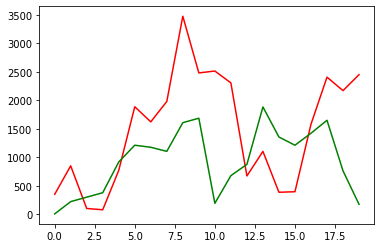

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(pr, color='red')
plt.plot(data['Y'], color='green')
plt.show()

Что было бы, если бы мы попробовали найти закономерность только от цены и объема покупателей и рассматривали каждую модель отдельно.

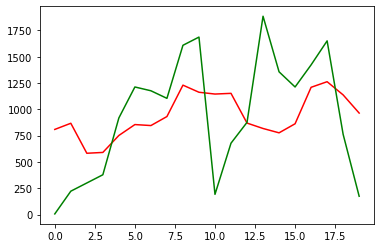

[   6.  222.  300.  378.  918. 1212. 1176. 1104. 1608. 1686.  192.  678.
  876. 1884. 1356. 1212. 1422. 1650.  762.  174.]


In [28]:
regr = LinearRegression().fit(data['X'], data['Y'])
pr = regr.predict(data['X'])
plt.figure()
plt.plot(pr, color='red')
plt.plot(data['Y'], color='green')
plt.show()
print(data['Y'])

Обновим данные, модель и предскажем результаты на тестовом наборе.

2022-02-21 18:35:44.836 | INFO     | research.fit_model:fit_model:79 - Model score: 0.39907140353557313
2022-02-21 18:35:44.837 | INFO     | research.fit_model:fit_model:80 - Train ds SMAPE: 62.610443429449305
2022-02-21 18:35:44.837 | INFO     | research.fit_model:fit_model:84 - Trivial solution train ds SMAPE: 74.47375934902935


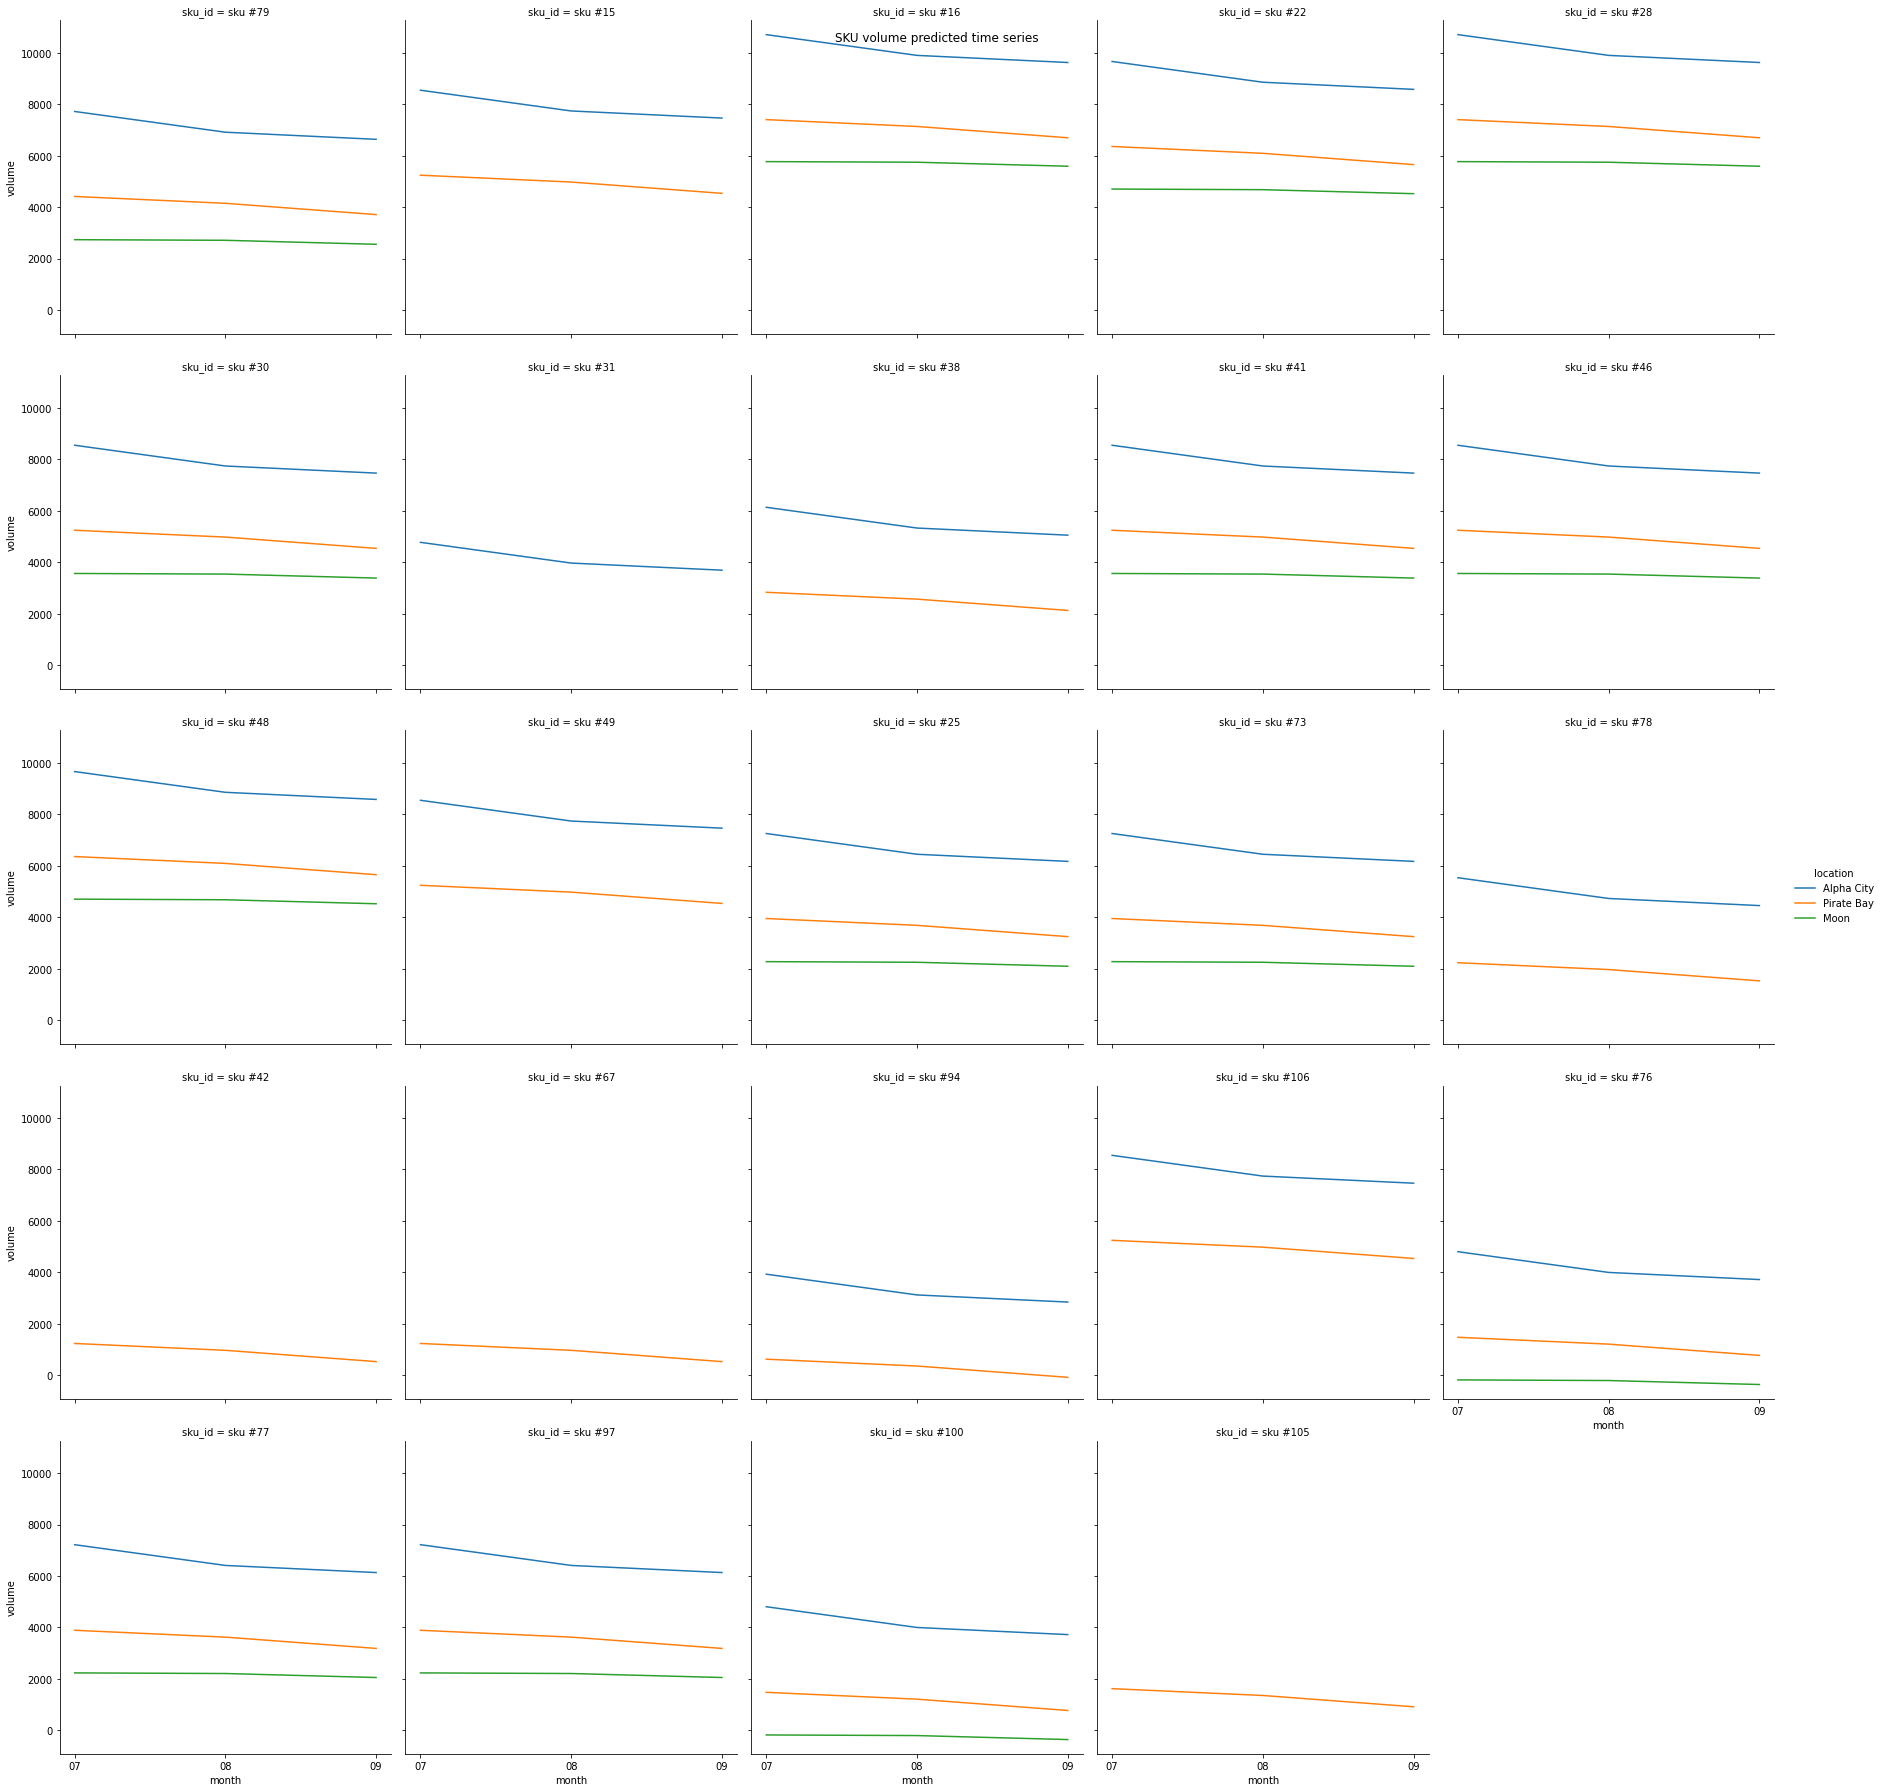

year month    location    sku_id       volume
0    2019    07  Alpha City   sku #79  7723.559023
1    2019    08  Alpha City   sku #79  6916.847113
2    2019    09  Alpha City   sku #79  6640.127013
3    2019    07  Pirate Bay   sku #79  4418.910571
4    2019    08  Pirate Bay   sku #79  4152.895170
..    ...   ...         ...       ...          ...
169  2019    08        Moon  sku #100  -206.155094
170  2019    09        Moon  sku #100  -361.482455
171  2019    07  Pirate Bay  sku #105  1618.122633
172  2019    08  Pirate Bay  sku #105  1352.107233
173  2019    09  Pirate Bay  sku #105   913.068949

[174 rows x 5 columns]

In [29]:
from research.fit_model import fit_model, infer_on_test

data = data_manager.get_data()
model = fit_model(data)
infer_on_test(data, model)


В результате обучения модели мы получили метрики. Из метрик мы видим, что примитивное решение, где в качестве предсказания мы берем среднее значение объема на всем датасете, обеспечивает лучшие результаты. Что не дает утешительных прогнозов по поводу полученной модели.

Для решения проблемы при достаточном количестве времени можно попытаться:  
1) Итеративный поиск лучшей комбинации признаков с последовательным исключением или добавлением различных комбинаций признаков, которые могут иметь или не иметь корреляцию с предсказываемой величиной.
2) Добавить признаки, описывающие некоторые временные зависимости: средняя цена за предыдущие три месяца, номер месяца, чтобы, вероятно, извлекать сезонные закономерности на спрос и тд.  
3) Искать и обрабатывать выбросы   
4) Добавлять различные виды нормализации   
5) Разные варианты процессинга пропущенных значений  
6) Исследование рядов на мультипликативные составляющие и логарифмирование с целью приведения к аддитивной


Подготовлен скрипт `research/fit_model.py`, который принимает в качестве входных аргументов пути к данным и путь к выходному файлу для сохранения и обучает модель, считает метрики, запускает оптимизацию и дампит результаты в выходной tsv файл. Пример запуска из корня проекта:

```bash
./research/fit_model.py --customers-data-tsv data/customers.tsv --sales-data-tsv data/sales.tsv --output-tsv /save/dir/output.tsv --log-level DEBUG
```

Moжно также отдельно импортировать функцию для оптимизации и вызвать оптимайзер.

In [32]:
from fit_model import predict_optimal_price

logger.remove()
log_level = 'DEBUG'
logger.add(sys.stderr, level=log_level)
price_idx = data['features_description'].tolist().index('price')
time_limit = data_manager.last_month_idx_cust - data_manager.last_month_idx
final_res = predict_optimal_price(
    data, model, price_idx, 0.15, time_limit)

2022-02-21 19:12:07.210 | DEBUG    | price_optimizer:optimize:37 - Init: [1.27632899 1.27632899 1.27632899]
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
2022-02-21 19:12:07.212 | DEBUG    | price_optimizer:optimize:42 - Solution
:       fun: 2.197111048676779e-05
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([-6.68348321e-06, -6.29405940e-06, -6.16047828e-06])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.27632899, 1.27632899, 1.27632899])
2022-02-21 19:12:07.213 | DEBUG    | price_optimizer:optimize:37 - Init: [1.27632899 1.27632899 1.27632899]
2022-02-21 19:12:07.215 | DEBUG    | price_optimizer:optimize:42 - Solution
:       fun: 2.938246948936e-05
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
   

2022-02-21 19:12:07.387 | DEBUG    | price_optimizer:optimize:42 - Solution
:       fun: 2.5624681929822358e-05
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([-7.50659683e-06, -7.33192496e-06, -7.04364152e-06])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.33901705, 1.33901705, 1.33901705])
2022-02-21 19:12:07.391 | DEBUG    | price_optimizer:optimize:37 - Init: [1.36835202 1.36835202 1.36835202]
2022-02-21 19:12:07.396 | DEBUG    | price_optimizer:optimize:42 - Solution
:       fun: 2.938475800253268e-05
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([-8.44645956e-06, -8.42564714e-06, -8.29152759e-06])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.36835202, 1.36835202, 1.36835202])
2022-02-21 19:12:07.399 | DEBUG    | price_optimi

2022-02-21 19:12:07.466 | DEBUG    | price_optimizer:optimize:37 - Init: [1.35406219 1.35406219 1.35406219]
2022-02-21 19:12:07.467 | DEBUG    | price_optimizer:optimize:42 - Solution
:       fun: 2.1553633566984668e-05
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([-6.25330085e-06, -5.87853538e-06, -5.74998262e-06])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.35406219, 1.35406219, 1.35406219])
2022-02-21 19:12:07.468 | DEBUG    | price_optimizer:optimize:37 - Init: [1.35406219 1.35406219 1.35406219]
2022-02-21 19:12:07.476 | DEBUG    | price_optimizer:optimize:42 - Solution
:       fun: 2.9225857826536003e-05
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([-8.67481685e-06, -8.44759984e-06, -8.07259471e-06])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: 

2022-02-21 19:12:07.562 | DEBUG    | price_optimizer:optimize:37 - Init: [1.36835202 1.36835202 1.36835202]
2022-02-21 19:12:07.568 | DEBUG    | price_optimizer:optimize:42 - Solution
:       fun: 2.915765329077369e-05
 hess_inv: array([[18894.34818068, 18817.89378764, 18331.64958612],
       [18817.89378764, 18743.74073692, 18258.4384496 ],
       [18331.64958612, 18258.4384496 , 17787.65027155]])
      jac: array([-6.50971538e-06, -6.48371724e-06, -6.31618127e-06])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 3
     njev: 10
   status: 0
  success: True
        x: array([2.1473998 , 2.14428852, 2.12423874])
2022-02-21 19:12:07.571 | DEBUG    | price_optimizer:optimize:37 - Init: [1.33901705 1.33901705 1.33901705]
2022-02-21 19:12:07.576 | DEBUG    | price_optimizer:optimize:42 - Solution
:       fun: 2.187719711375899e-05
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([-6.41462861e-06, -6.02852674e-06, -5.89608521e-06